# v3_from_t3p2_ph1.ipynb

This is a copy of  t3p2_from_rl5El.ipynb gradually adapted to control the `bouncy_planar_arm_v3` plant, following the design in `net_from_cfg.py`.

In this first phase of adaptation, we create a version without the spinal cord network. In other words no $\alpha$ motorneurons (`AL`), and no dual `CE,CI` populations for each muscle. Instead we just have 6 `C` units with the agonist-antagonist relations we had in the `net_from_cfg`.

In [1]:
%cd /home/z/projects/draculab/

/home/z/projects/draculab


In [2]:
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

In [3]:
#===================================================================
#================ CREATE THE NETWORK ===============================
#===================================================================

np.random.seed(123456) # always the same random values
#np.random.seed()   # different random values every run

# some parameters 
t_pres = 50. # interval that desired values last
par_heter = 0.01 # range of heterogeneity as a fraction of the original value
M_size = 12 # number of units in the M population
SPF_size = 12 # number of units in the SPF population
rand_targets = True # whether to train using a large number of random targets
cfg = {'g_e_factor' : 1.,
       'b_e' : 3. }

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Parameter dictionaries for the network and the plant
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 8 }
# plant parameters
P_params = {'type' : plant_models.bouncy_planar_arm_v3,
          'mass1': 1.,
          'mass2': 1.,
          's_min' : -0.8,
          'p1' : (-0.01, 0.04),
          'p2' : (0.29, 0.03),
          'p3' : (0., 0.05),
          'p5' : (0.01, -0.05),
          'p10': (0.29, 0.03),
          'init_q1': 0.,
          'init_q2': np.pi/2.,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 3.,
          'mu2': 3.,
          'l_torque' : 0.01,
          'l_visco' : 0.01,
          'g_e' : cfg['g_e_factor']*np.array([18., 20., 20., 18., 22., 23.]),
          'l0_e' : [1.]*6,
          'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,10.,10.]),
          'II_gain' : 2.*np.array([3., 8., 8., 3., 8., 8.]),
          'Ib_gain' : 1.,
          'T_0' : 10.,
          'k_pe_e' : 20.,  #8
          'k_se_e' : 20., #13
          'b_e' : cfg['b_e'],
          'g_s' : 0.02,
          'k_pe_s' : 2., 
          'k_se_s' : 2.,
          'g_d' : 0.01,
          'k_pe_d' : .2, #.1,
          'k_se_d' : 1., #2.,
          'b_s' : .5,
          'b_d' : 2.,#3.,
          'l0_s': .7,
          'l0_d': .8,
          'fs' : 0.1,
          'se_II' : 0.5,
          'cd' : 0.5,
          'cs' : 0.5,
          'tau' : 0.1   # ficticious time constant used in create_freqs_steps
           }
#--------------------------------------------------------------------
# Unit parameters
#--------------------------------------------------------------------
randz = lambda n: (1. + par_heter*(np.random.rand(n)-0.5))

A_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.01, # 0.02
            'tau_fast': 0.005,
            'thresh' : 0. } 
C_params = {'type' : unit_types.rga_sig,
            'integ_meth' : 'euler_maru', #'euler_maru', #'odeint',
            'init_val' : [r*np.array([0.5]) for r in np.random.random(6)],
            'multidim' : False,
            'slope' : 2.,
            'thresh' : 0.2, 
            'integ_amp' : 0., 
            'tau' : 0.02,
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : 3.,
            'custom_inp_del' : 150,
            'delay' : 0.31,
            'mu' : 0.,
            'sigma' : 0.4 }
M_params = {'type' : unit_types.m_sig,
            'thresh' : 0.5 * randz(M_size),
            'slope' : 2.5 * randz(M_size),
            'init_val' : 0.2 * randz(M_size),
            'delay' : 0.35,
            'n_ports' : 4,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 8.,
            'tau' : 0.01 * randz(M_size),
            'integ_amp' : 0.,
            'custom_inp_del' : int(np.round(0.3/net_params['min_delay'])) ,
            'des_out_w_abs_sum' : 1.6 }
# SF, SP
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : np.array([0.3]*6),
             'slope' : np.array([4.]*6),
             'init_val' : 0.2,
             'tau' : 0.02 }  # 0.05
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.01,
             'tau_mid' : 0.2,
             'function' : lambda t: None }
# 1-D error units
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3 * randz(SPF_size),
              'slope' : 6. * randz(SPF_size),
              'init_val' : 0.3 * randz(SPF_size),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz(SPF_size) }      
# units to track synaptic weights or other values
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#--------------------------------------------------------------------
# Connection dictionaries
#--------------------------------------------------------------------
# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

antagonists += [(p[1],p[0]) for p in antagonists]
part_antag += [(p[1],p[0]) for p in part_antag]
synergists += [(p[1],p[0]) for p in synergists]
part_syne += [(p[1],p[0]) for p in part_syne]
all_pairs = [(i,j) for i in range(6) for j in range(6)]

# Afferent to motor error selection
A__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
A__M_syn = {'type' : synapse_types.inp_sel, 
            'inp_ports' : 2, # the default for m_sig targets
            'error_port' : 1, # the default for m_sig targets
            'aff_port' : 2,
            'lrate' : 5., # negative rate for m_sig targets with value inputs
            'w_sum' : .4,
            'w_max' : 0.3,
            'init_w' : .1 }
A__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
A__SF_syn = {'type' : synapse_types.static,
             'init_w' : [1.]*6 }
# lateral connections in C
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.01 }
C__C_syn_antag = {'type' : synapse_types.static,
                  'inp_ports': 1, # "lateral" port of rga_21 synapses
                  'init_w' : -1.5 }
C__C_syn_p_antag = {'type' : synapse_types.static,
                    'inp_ports': 1,
                    'init_w' : -.5 }
C__C_syn_syne = {'type' : synapse_types.static,
                  'inp_ports': 1,
                  'init_w' : .5 }
C__C_syn_p_syne = {'type' : synapse_types.static,
                  'inp_ports': 1,
                  'init_w' : .2 }
# spinal units to plant
C__P_conn = {'inp_ports' : list(range(6)),
             'delays': 0.02 }
C__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# motor to spinal
M__C_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__C_syn = {'type' : synapse_types.rga_21,
            'lrate': 100.,
            'inp_ports': 0,
            'w_sum' : 2.,
            'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1}}
# motor error lateral connections
M__M_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.02 } # the dealy assumes an intermediate interneuron
M__M_syn = {'type' : synapse_types.static,
            'inp_ports': 3, # default for m_sig targets
            'init_w' : -1. }
# plant to afferent
idx_aff = np.arange(22,40) # indexes for afferent output in the arm
P__A_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
P__A_syn = {'type' : synapse_types.static,
            'init_w' : [1.]*18 }
# SF/SP to SPF
SFe__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SPF to M
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.02 }
SPF__M_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'init_w' : 1. }
# sensory error lateral connections
SPF__SPF_conn = {'rule': 'one_to_one',
                 'allow_autapses' : False,
                 'delay' : 0.02 }
SPF__SPF_syn = {'type' : synapse_types.static,
                'inp_ports': 0,
                'init_w' : -.5 } # the dealy assumes an intermediate interneuron
# utility function to set C_params['custom_inp_del']
def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.

        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-A-M-C.

        Args:
            f : main oscillation frequency of in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    a_del = np.arctan(np.mean(A_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [C__P_conn['delays'], np.mean(P__A_conn['delays']),
         A__M_conn['delay'], M__C_conn['delay'] ]
    time_del = p_del + a_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps

C_time_del, C_del_steps = approx_del(1.)
C_params['custom_inp_del'] = C_del_steps

#--------------------------------------------------------------------
# CREATING NETWORK AND UNITS
#--------------------------------------------------------------------
net = network(net_params)

A = net.create(18, A_params)
C = net.create(6, C_params)
M = net.create(12, M_params)
P = net.create(1, P_params)
SF = net.create(6, SF_params)
SP = net.create(6, SP_params)
SPF = net.create(12, SPF_params)

# tracking units
M_C0_track = net.create(M_size, track_params) # to track weights from M to C0
A_M0_track = net.create(12, track_params) # to track weights from A to M0

#--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--
# SET THE PATTERNS IN SP -----------------------------------------------------
# list with hand coordinates [x,y] (meters)
if rand_targets is False:
    hand_coords = [[0.3, 0.45], 
                   [0.35, 0.4],
                   [0.4, 0.35],
                   [0.35, 0.3],
                   [0.3, 0.25],
                   [0.25, 0.3],
                   [0.2, 0.35],
                   [0.25, 0.4]]
else:
    # creating a list of random coordinates to use as targets
    min_s_ang = -0.1 # minimum shoulder angle
    max_s_ang = 0.8  # maximum shoulder angle
    min_e_ang = 0.2 # minimum elbow angle
    max_e_ang = 2.3 # maximum elbow angle
    n_coords = 1000 # number of coordinates to generate
    l_arm = net.plants[P].l_arm # upper arm length
    l_farm = net.plants[P].l_farm # forearm length
    hand_coords = [[0.,0.] for _ in range(n_coords)]
    s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
    e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
    for i in range(n_coords):
        hand_coords[i][0] = l_arm*np.cos(s_angs[i]) + l_farm*np.cos(s_angs[i]+e_angs[i]) # x-coordinate
        hand_coords[i][1] = l_arm*np.sin(s_angs[i]) + l_farm*np.sin(s_angs[i]+e_angs[i]) # y-coordinate

# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(net.plants[P].coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
#Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
#Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
#Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the afferent units
P__A_ws = np.array(P__A_syn['init_w'][12:18])
#Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
A_thr = np.array([net.units[u].thresh for u in A[12:18]])
A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from A to SF
SF_arg = A__SF_syn['init_w']*A_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP
m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
    #m_idxs[0] = 0 # for testing
A_us = [net.units[u] for u in A]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor(t/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        A__SF_syn['init_w'][idx] * (
                        np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                        net.units[A[12+idx]].thresh, 0.))))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))
#--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--
        
#--------------------------------------------------------------------
# CONNECTING
#--------------------------------------------------------------------
# From afferent units
net.connect(A[:12], M, A__M_conn, A__M_syn)
net.connect(A[12:18], SF, A__SF_conn, A__SF_syn)
# intraspinal connections
for pair in all_pairs:
    if pair in synergists:
        net.connect([C[pair[0]]], [C[pair[1]]], C__C_conn, C__C_syn_syne)
    elif pair in part_syne:
        net.connect([C[pair[0]]], [C[pair[1]]], C__C_conn, C__C_syn_p_syne)
    elif pair in antagonists:
        net.connect([C[pair[0]]], [C[pair[1]]], C__C_conn, C__C_syn_antag)
    elif pair in part_antag:
        net.connect([C[pair[0]]], [C[pair[1]]], C__C_conn, C__C_syn_p_antag)
# from spine to plant
net.set_plant_inputs(C, P, C__P_conn, C__P_syn)
# From M 
net.connect(M, C, M__C_conn, M__C_syn)
net.connect(M, M, M__M_conn, M__M_syn)
# From plant to afferents
net.set_plant_outputs(P, A, P__A_conn, P__A_syn) 
# From SF to SPF
net.connect(SF, SPF[:6], SFe__SPF_conn, SFe__SPF_syn)
net.connect(SF, SPF[6:12], SFi__SPF_conn, SFi__SPF_syn)
net.connect(SP, SPF[:6], SPi__SPF_conn, SPi__SPF_syn)
net.connect(SP, SPF[6:12], SPe__SPF_conn, SPe__SPF_syn)
# From SPF
net.connect(SPF, M, SPF__M_conn, SPF__M_syn)
net.connect(SPF, SPF, SPF__SPF_conn, SPF__SPF_syn)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_C0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[C[0]][idx].w
for idx in range(len(M)):
    net.units[M_C0_track[idx]].set_function(M_C0_fun(idx))
# This assumes the first connections to M are AF-->M    
def A_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx, uid in enumerate(A_M0_track):
    net.units[uid].set_function(A_M0_fun(idx))


# SETTING TRACKING OF PLASTICITY FACTORS FOR M0-->C0
# net.units[xp_track[0]].set_function(lambda t: net.units[C[0]].del_avg_inp_deriv_mp[1])
# po_de = net.units[C[0]].custom_inp_del
# net.units[up_track[0]].set_function(lambda t: net.units[C[0]].get_lpf_fast(po_de) - 
#                                     net.units[C[0]].get_lpf_mid(po_de))
# net.units[sp_track[0]].set_function(lambda t: net.units[C[0]].avg_inp_deriv_mp[0])
# ds = net.syns[C[0]][0].delay_steps
# net.units[spj_track[0]].set_function(lambda t: net.units[M[0]].get_lpf_fast(ds) - 
#                                      net.units[M[0]].get_lpf_mid(ds))


In [4]:
# Run simulations
sim_time = 100.
start_time = time.time()
times, data, plant_data  = net.flat_run(sim_time)

data = np.array(data)
print('Execution time is %s seconds' % (time.time() - start_time))

Execution time is 353.0600674152374 seconds


[0.17045236 0.16941207 0.16900847 0.16948301 0.16831857 0.16865301
 0.11866661 0.11782561 0.11932462 0.11871912 0.11635826 0.11935381]
[0.35661917 0.355532   0.35638281 0.356288   0.3562294  0.35560232
 0.3280159  0.32636221 0.32644871 0.32795164 0.32684165 0.32595842]


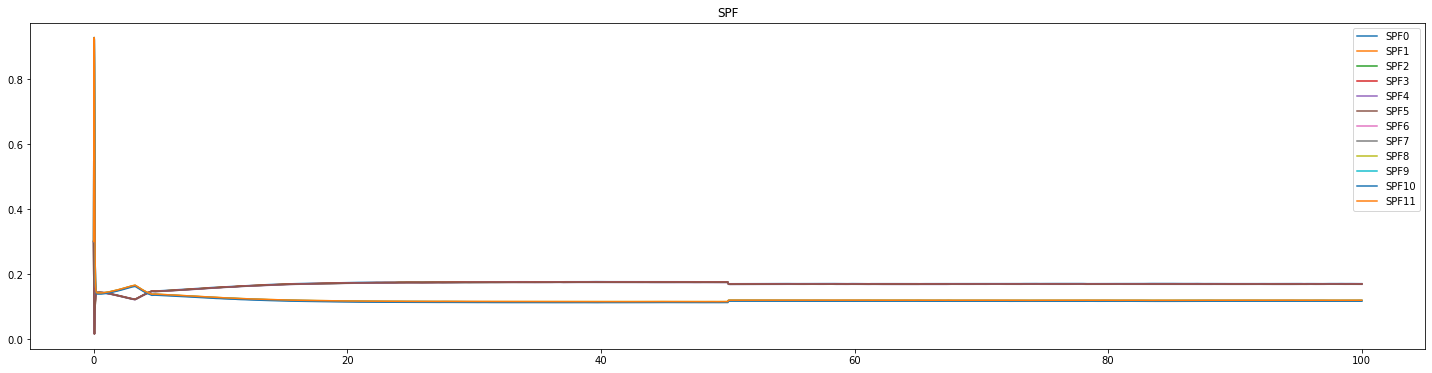

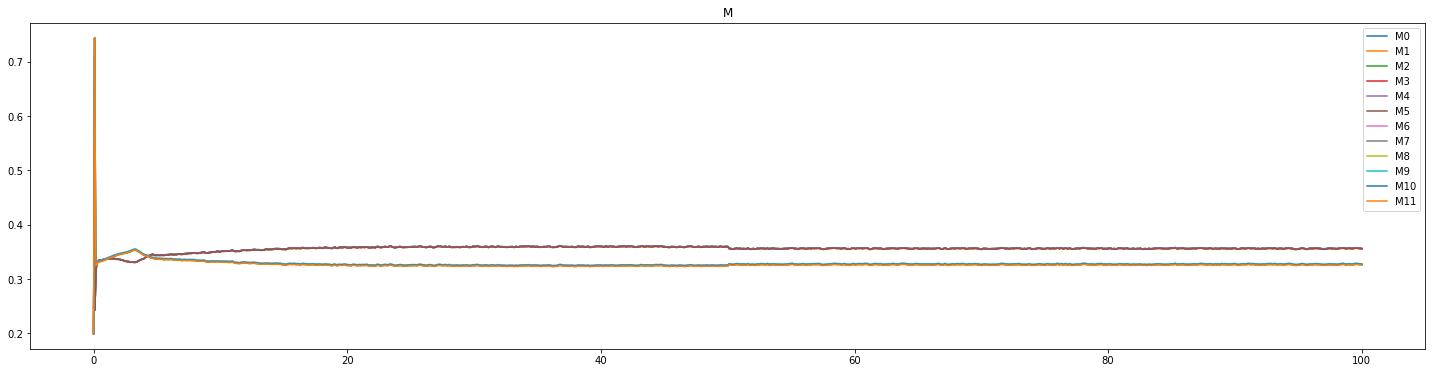

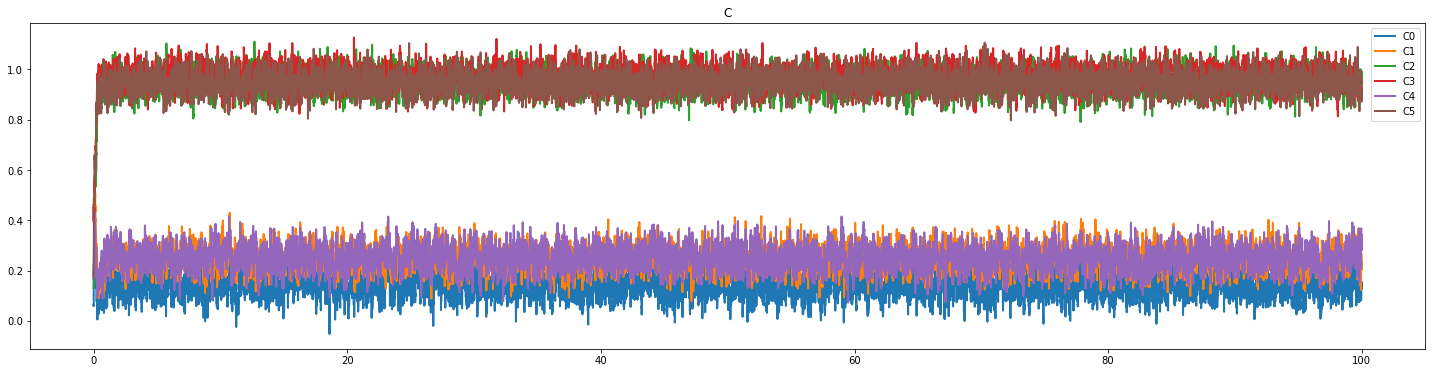

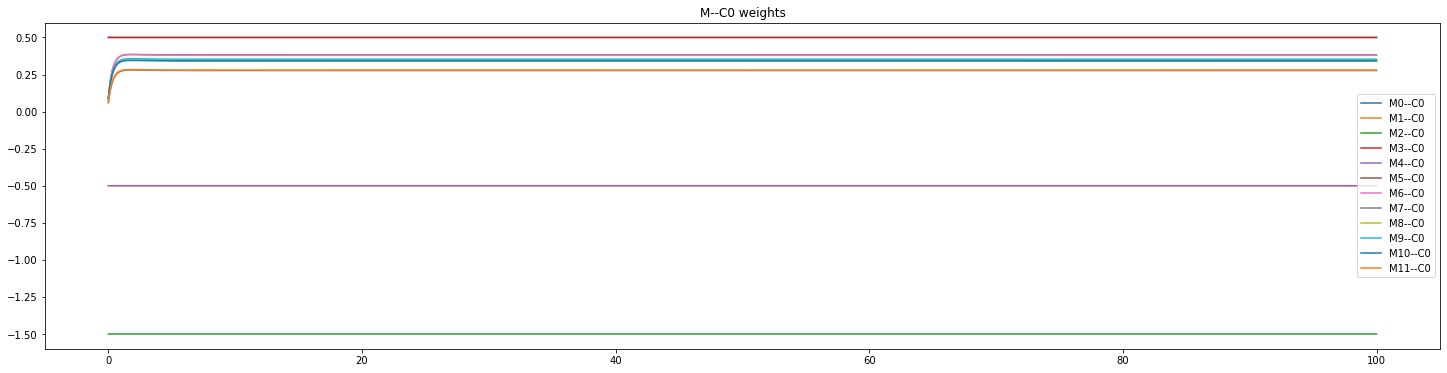

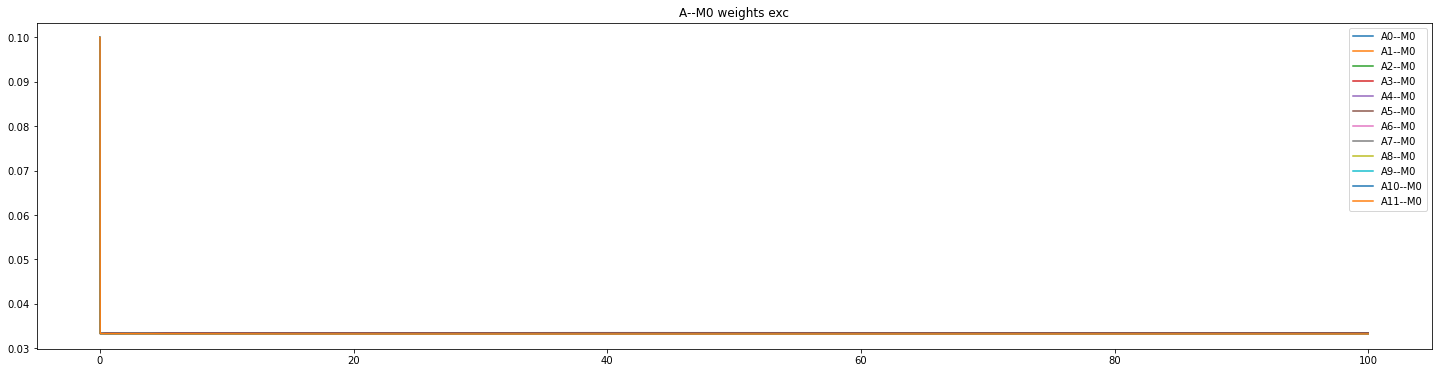

In [5]:
arm_activs = plant_data[P]
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
C_data = np.array(data[C])
plt.plot(times, C_data.transpose(), linewidth=2)
C_legends = ['C'+str(i) for i in range(len(C))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_C0_track])
plt.plot(times, w_track_data.transpose())
M_C0_legends = ['M'+str(i)+'--C0' for i in range(len(M_C0_track))]
plt.legend(M_C0_legends)
plt.title('M--C0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track[0:18]])
plt.plot(times, w_track_data2.transpose())
A_M0_legends = ['A'+str(i)+'--M0' for i in range(len(A_M0_track[:12]))]
plt.legend(A_M0_legends)
plt.title('A--M0 weights exc')
"""
W_fig3 = plt.figure(figsize=fs)
w_track_data3 = np.array(data[AF_M0_track[18:]])
plt.plot(times, w_track_data3.transpose())
AF_M0_legends2 = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track[18:]))]
plt.legend(AF_M0_legends2)
plt.title('AF--M0 weights inh')
"""

plt.show()

shoulder angle: -0.784635, shoulder vel: 0.290167
A_data:
[1.57727117e-001 2.07296525e-001 4.96729951e-001 4.60521823e-001
 2.44985260e-001 5.38972483e-001 1.76256931e-001 2.43993848e-001
 3.45845952e-323 1.66814374e-002 2.45374658e-001 3.45845952e-323
 3.73890245e-001 4.08641833e-001 3.45845952e-323 9.62764783e-002
 4.05626474e-001 1.43730639e-002]


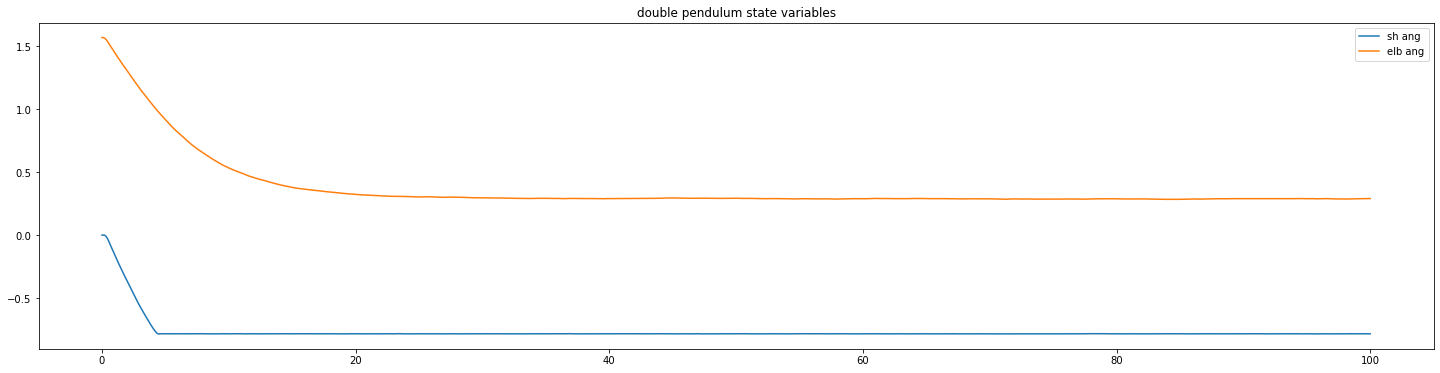

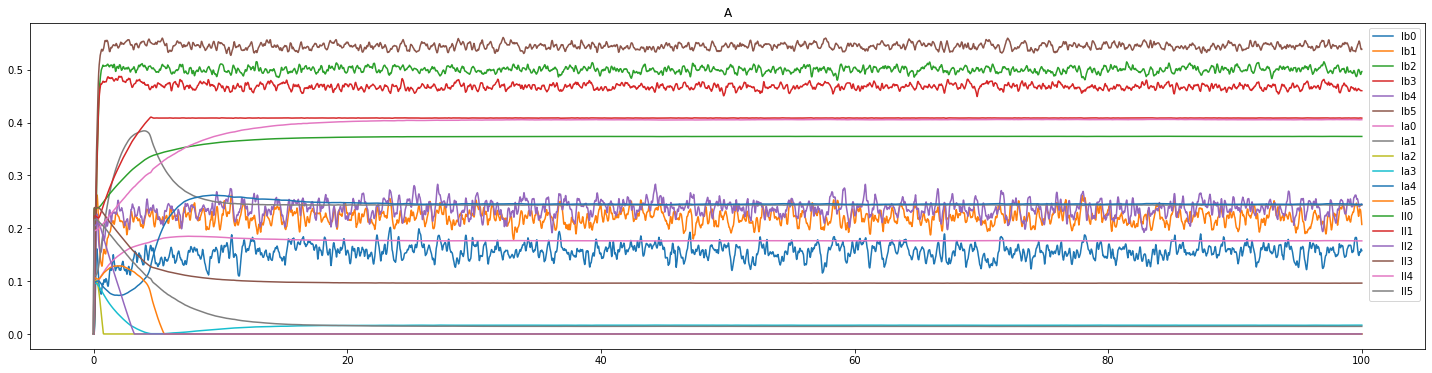

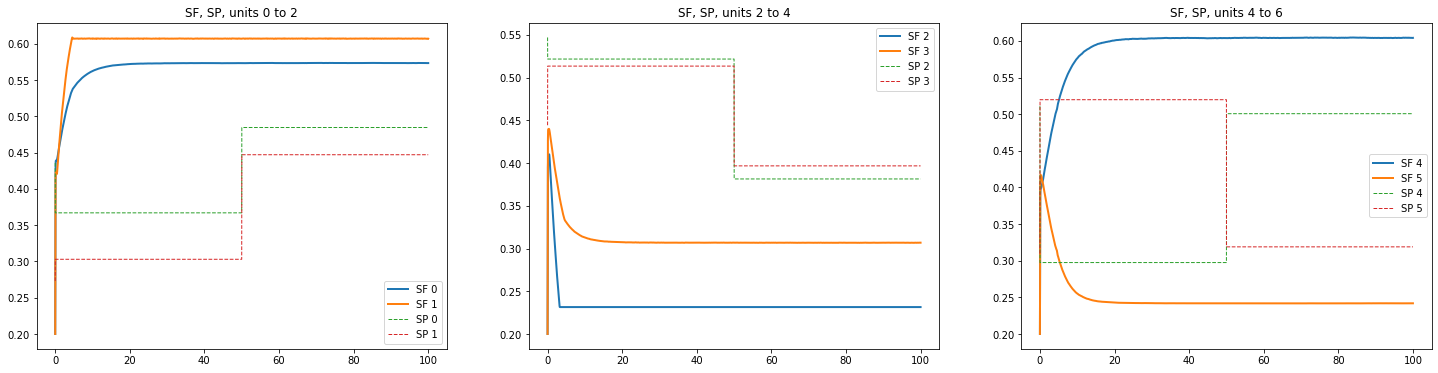

SF = 
[0.57337504 0.60704918 0.23147522 0.30681226 0.60407048 0.2418632 ]
SP = 
[0.48457426 0.44704932 0.38141116 0.39671947 0.50063196 0.31889044]


In [6]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A[0:18]])
plt.plot(times, A_data.transpose())
A_legends = ['Ib' + str(i) for i in range(6)] + \
            ['Ia' + str(i) for i in range(6)] + \
            ['II' + str(i) for i in range(6)]
plt.legend(A_legends)
plt.title('A')
print('A_data:')
print(A_data[:,-1])

#fs = (30,6)
# SF, SP
SF_fig, axs = plt.subplots(1, 3, figsize=(fs[0], fs[1]))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
if 'lowpass_SP' in locals() and lowpass_SP is True:
    LPF_SP_data = np.array(data[LPF_SP])
for col in range(3):
    ax = axs[col]
    base = 2*col
    ax.plot(times, SF_data[base:base+2, :].transpose(), linewidth=2)
    ax.plot(times, SP_data[base:base+2, :].transpose(), '--', linewidth=1)
    if 'lowpass_SP' in locals() and lowpass_SP is True:
        ax.plot(times, LPF_SP_data[base:base+2, :].transpose(), linewidth=2)
    ax.set_title('SF, SP, units %d to %d' % (base, base+2))
    SF_legends = ['SF '+ str(base+i) for i in range(2)]
    SP_legends = ['SP '+ str(base+i) for i in range(2)]
    ax.legend(SF_legends + SP_legends)

plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

average error: 0.663307


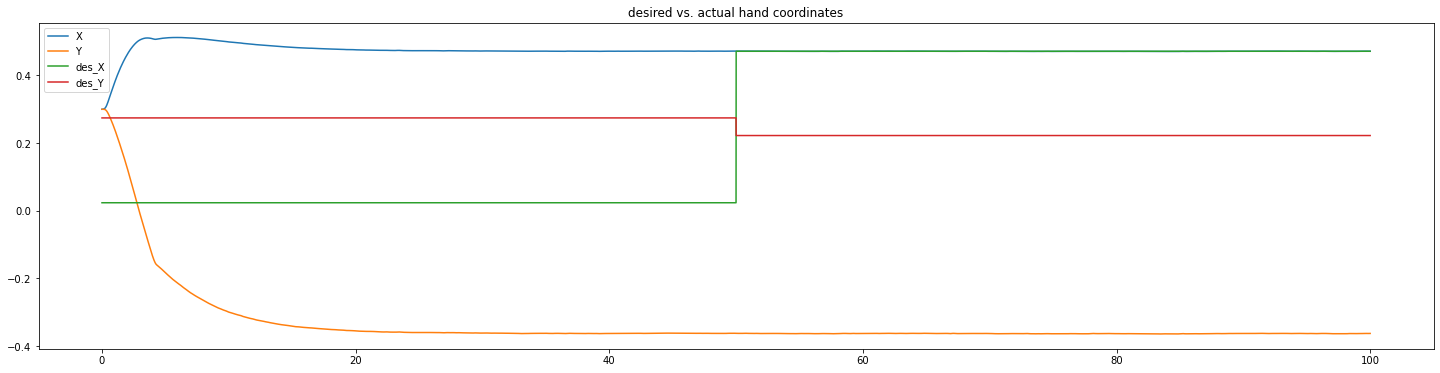

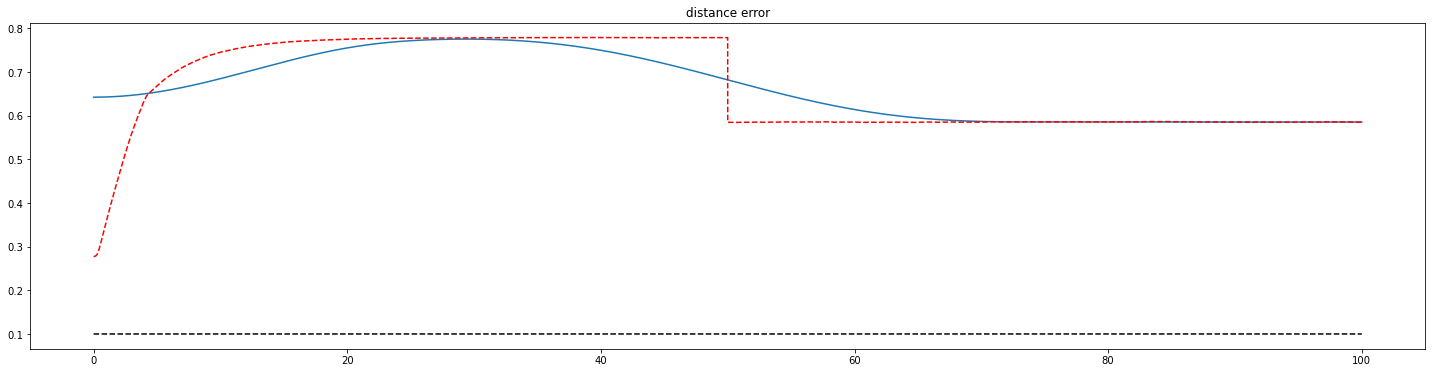

In [31]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times-start_t)/t_pres).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times/t_pres).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)
plt.plot(times, des_coords)
plt.title('desired vs. actual hand coordinates')
plt.legend(['X', 'Y', 'des_X', 'des_Y'])

err_fig = plt.figure(figsize=fs)
w_len = 10001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times, smooth_hand_error)
plt.plot(times, hand_error, 'r--')
plt.plot(times, 0.1+np.zeros(smooth_hand_error.size), 'k--')
plt.title('distance error')
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))

plt.show()

Ib avg for muscle 0= 0.13473019167942576
Ia avg for muscle 0= 0.19319265272304692
II avg for muscle 0= 0.4476091254115152
Ib avg for muscle 1= 0.19472683073119648
Ia avg for muscle 1= 0.2833854478356025
II avg for muscle 1= 0.4997541605548825
Ib avg for muscle 2= 0.6454801362898356
Ia avg for muscle 2= -0.08461287427682909
II avg for muscle 2= -0.05965387377167898
Ib avg for muscle 3= 0.5952583647267226
Ia avg for muscle 3= 0.016310883780983942
II avg for muscle 3= 0.10601975418636952
Ib avg for muscle 4= 0.21372897772970123
Ia avg for muscle 4= 0.27400074653873846
II avg for muscle 4= 0.48909881420001095
Ib avg for muscle 5= 0.7204252080390993
Ia avg for muscle 5= -0.023510801904640638
II avg for muscle 5= 0.023504262811155623


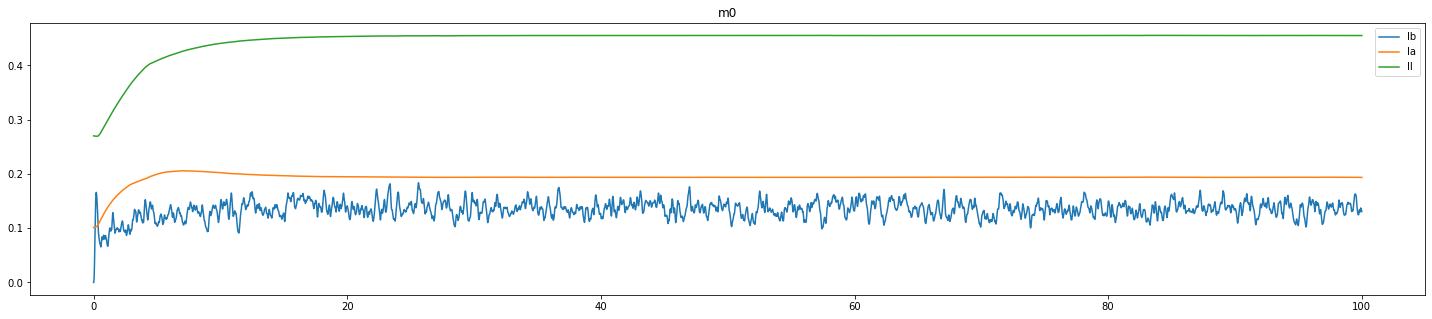

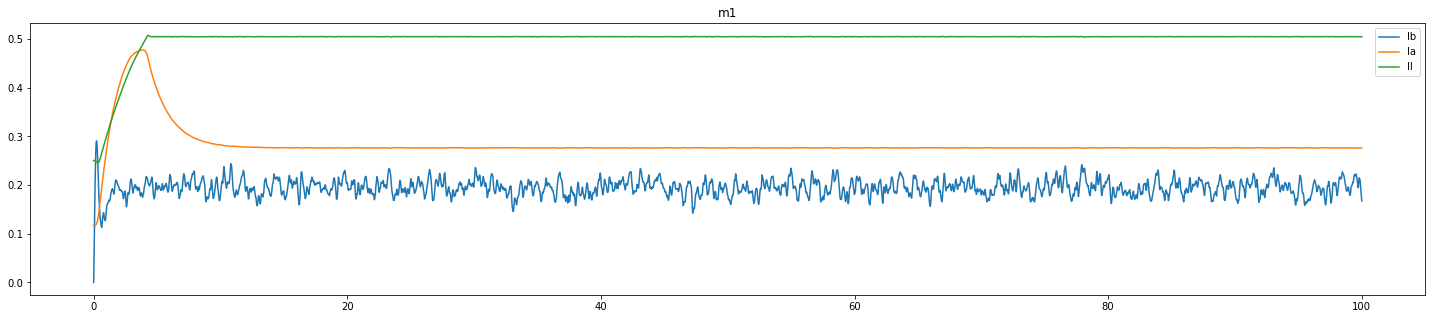

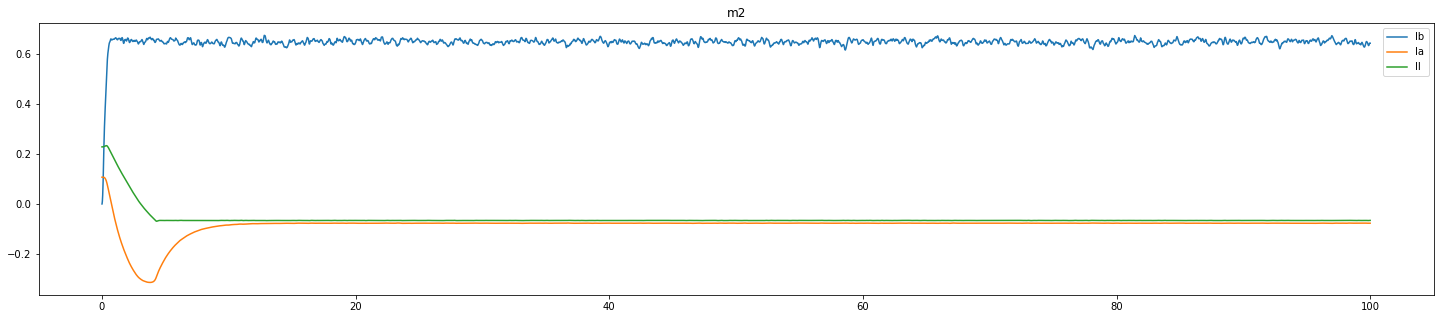

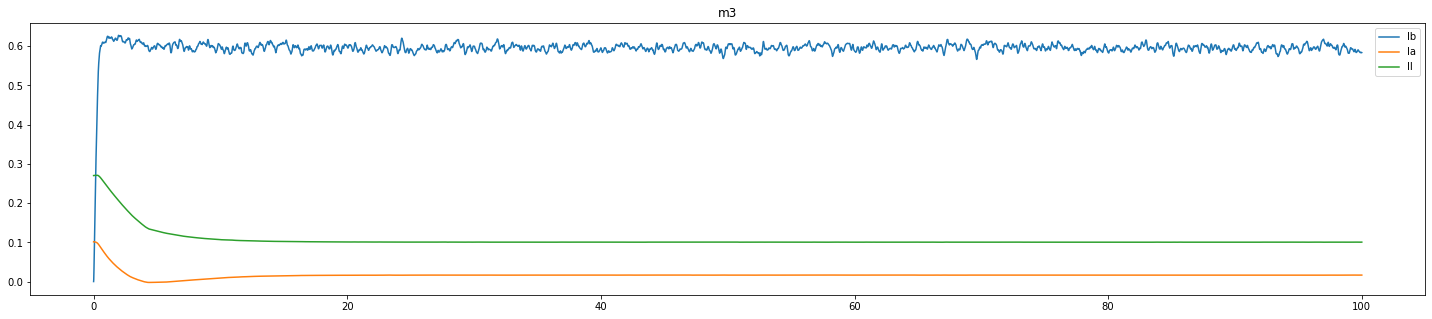

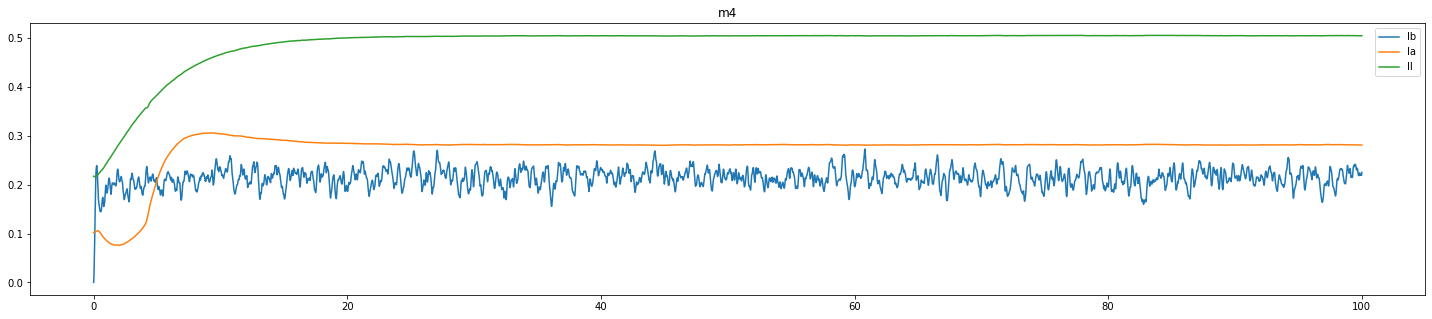

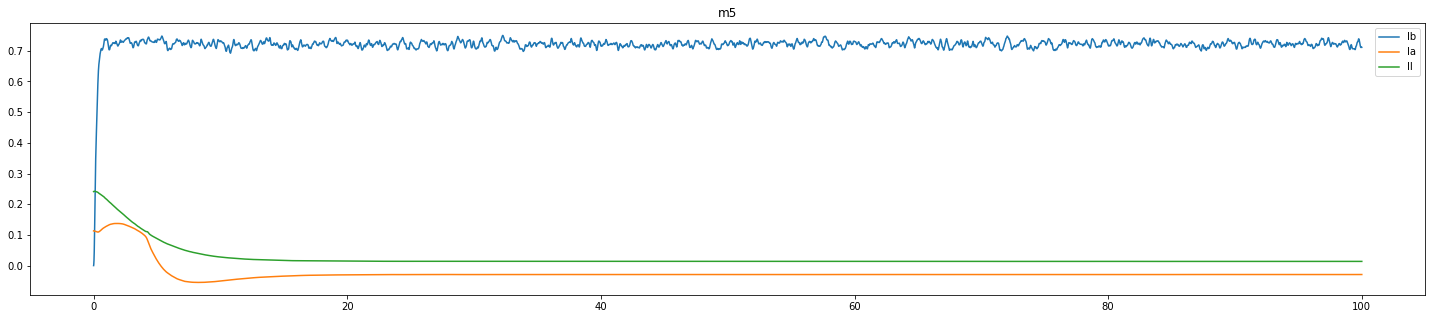

In [33]:
# plotting muscle outputs
fs2 =(25,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

In [19]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=500*200
second_idx=600*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [24]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

---